# AIPI 590 - XAI | Assignment #3
### Explainable Techniques II
### Kayla Haeussler


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khaeuss808/AIPI590_Part2_ExplainableAITechniques/blob/main/Explainable_TechniquesII.ipynb)

In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns, matplotlib.pyplot as plt

# For XAI techniques
import shap

from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

I searched for a dataset on Kaggle, this dataset about wine caught my eye
https://www.kaggle.com/code/gamzegedik044/wine-type-classification-quality-prediction 

In [3]:
df = pd.read_csv("wine_quality_merged.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Exploring the data a bit

In [4]:
df["type"].value_counts()

type
white    4898
red      1599
Name: count, dtype: int64

In [5]:
df.groupby("type").agg(["mean", "std"])

fixed acidity           volatile acidity           citric acid  \
               mean       std             mean       std        mean   
type                                                                   
red        8.319637  1.741096         0.527821  0.179060    0.270976   
white      6.854788  0.843868         0.278241  0.100795    0.334192   

                residual sugar           chlorides            ...   density  \
            std           mean       std      mean       std  ...      mean   
type                                                          ...             
red    0.194801       2.538806  1.409928  0.087467  0.047065  ...  0.996747   
white  0.121020       6.391415  5.072058  0.045772  0.021848  ...  0.994027   

                       pH           sulphates              alcohol            \
            std      mean       std      mean       std       mean       std   
type                                                                           
red    0.001887  3.311113  0.154386  0.658149  0.169507  10.422983  1.065668   
white  0.002991  3.188267  0.151001  0.489847  0.114126  10.514267  1.230621   

        quality            
           mean       std  
type                       
red    5.636023  0.807569  
white  5.877909  0.885639  

[2 rows x 24 columns]

I want to use a random forest model here because they are my favorite. It has been a while since I have created one of these models, so I am using the following Data Camp tutorial as a reference
https://www.datacamp.com/tutorial/random-forests-classifier-python

Prepping data for model creating

In [9]:
y = df["type"]
X = df.drop("type", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Creating Random Forest Model

In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RF Model Accuracy: ", acc)

RF Model Accuracy:  0.9930769230769231


In [65]:
print(rf_model.classes_)
# this tells us that prediction of 0 is red and 1 is white

['red' 'white']


## Exploratory Analsysis  
To determine the amount of correlation between features

In [38]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

#### Checking correlation between features and the target variable (wine type)

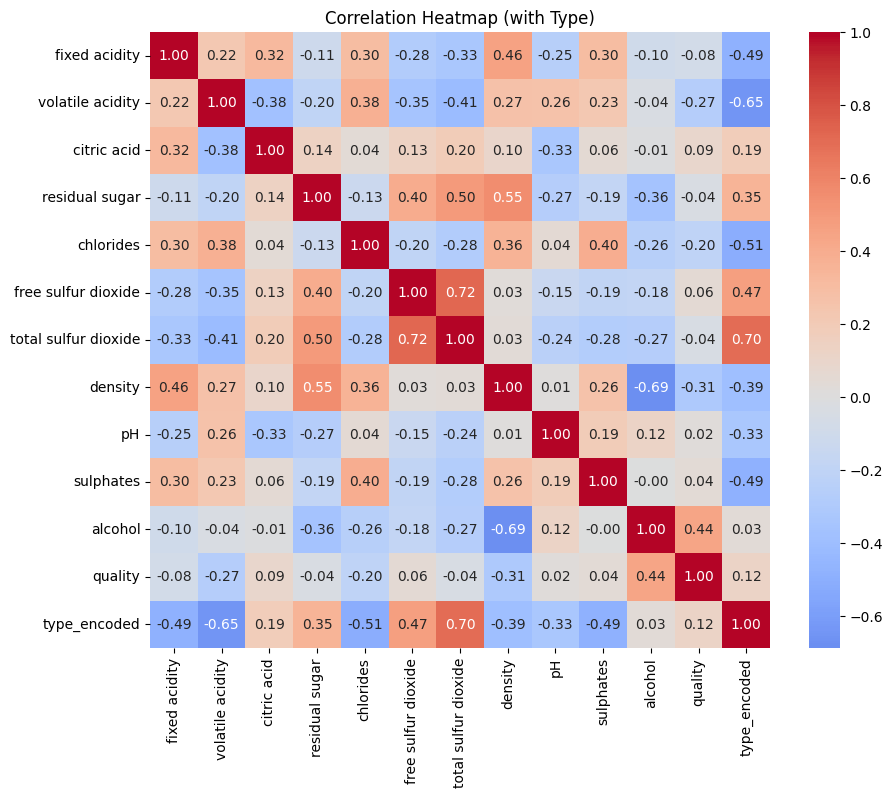

In [63]:
# The below code was generated using ChatGPT 5 on 9/28/25 at 7:18pm
# My prompt relayed that I wanted to make a correlation heatmap of all of my features
# and my categorical outcome, I adapted slightly for visual appearance


# Encode 'type' as numeric
df["type_encoded"] = df["type"].map({"red": 0, "white": 1})

corr = df.drop(columns=["type"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (with Type)")
plt.show()

Looking at the correlation heatmap, nothing is extremely concerning, but there are a couple of relationships worth noting. As far as high correlations between features, total sulfur dioxide and free sulfur dioxide have a correlation of 0.72, alcohol and residual sugars have a correlation of 0.55, and alcohol and density have a correlation of -0.69. I am not super familiar with wine, but reading the data card on Kaggle as well as some Googling of total and free sulfur dioxide in wines, shows that total dioxide is the sum of free and bound sulfur dioxide, and while total and free dioxide rise together, two wines with the same total dioxide can have very different free dioxide, which explains both the high correlation and the decision of the Kaggle dataset creators to include both columns in the first place. As far as alcohol and density and alcohol and residual sugars, these relationsips are not surprising to me as higher alcohol drinks would have lower density and drinks with a lot of sugar would ahve higher density.  
  
As far as relationships between the features and our dependent variable 'type', notable correlations included fixed acidity (-0.49), volatile acidity (-0.65), chlorides (-0.51), free sulfur dioxixde (0.47), total sulfur dioxide (0.70) and sulphates (-0.49). The correlations are not surprising to me as it makes sense that the different types of wines would be strongly tied to certain chemical properties. The variables provide useful information for distringuishing between red and white wines, which supports keeping them in the model

Sulfur Dioxide research source: https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/ 

## PDP Plots

The following text comes from Dr. Bent's global_explanations.ipynb, including the info here as it helps explain PDP

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model  

How it Works:  
1. Select feature of interest  
2. For every instance in training dataset:  
    Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid  
    Make predictions with the black box model for newly created instances  
    You now have a set of points for an instance with the feature value from the grid and the respective predictions  
3. Average across all instances and plot  

In [32]:
X.columns.values

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [64]:
features = X.columns.values

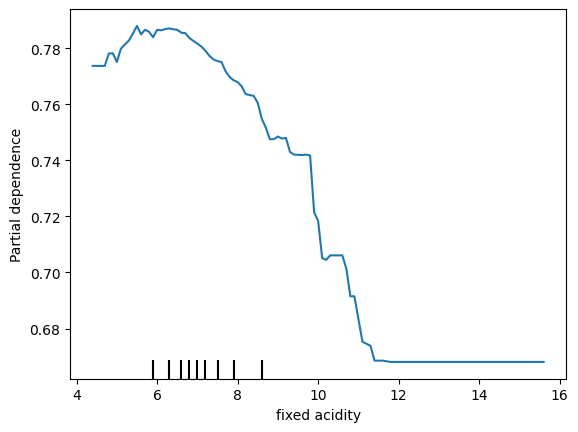

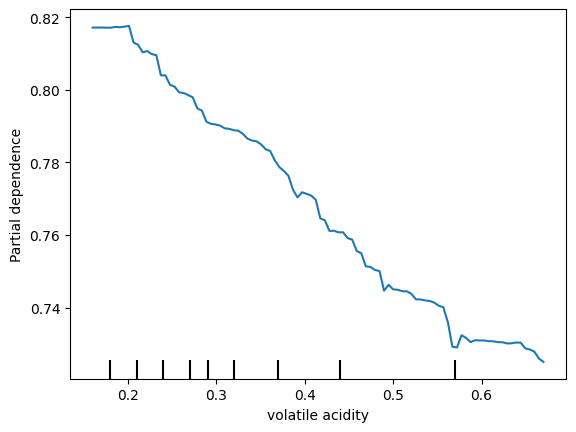

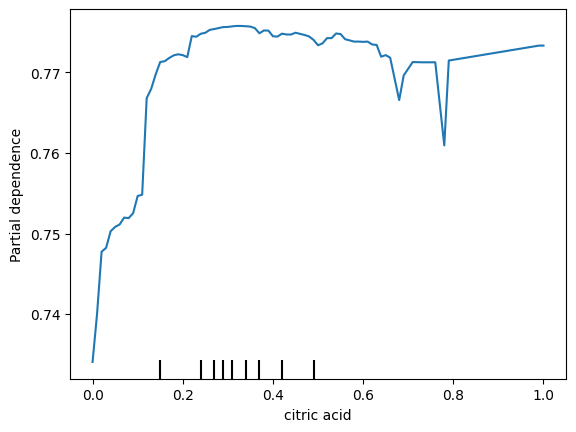

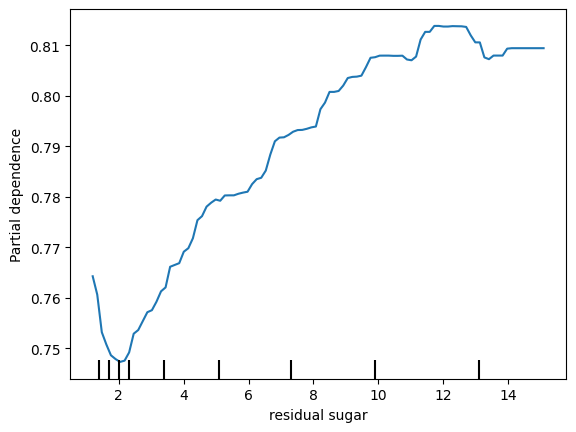

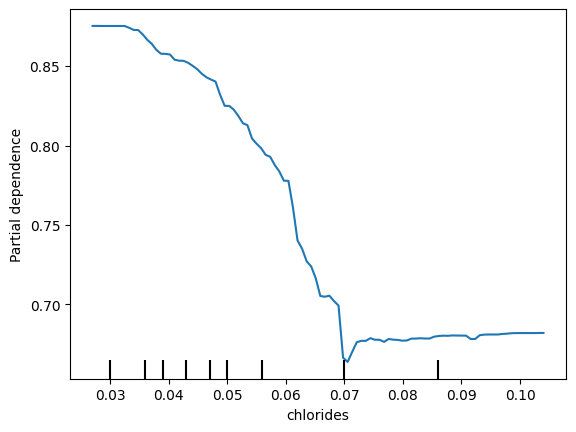

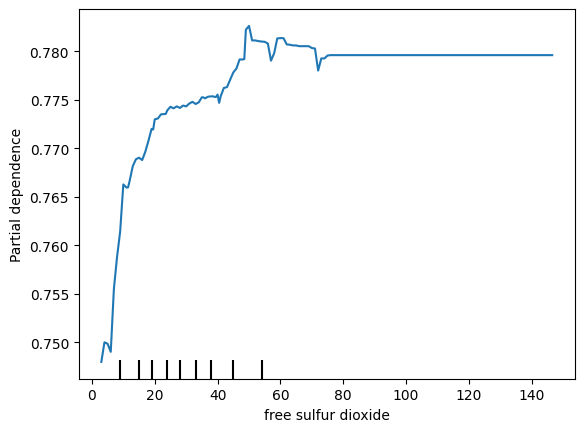

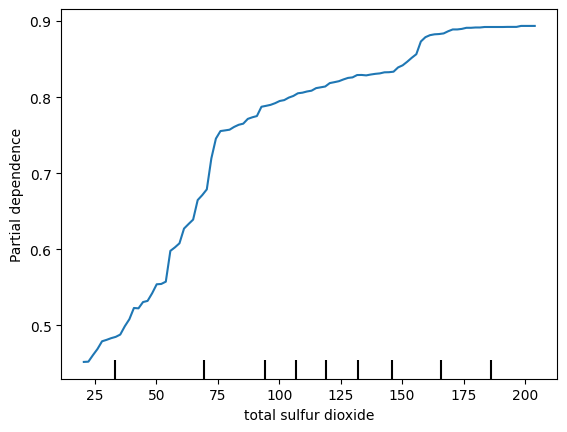

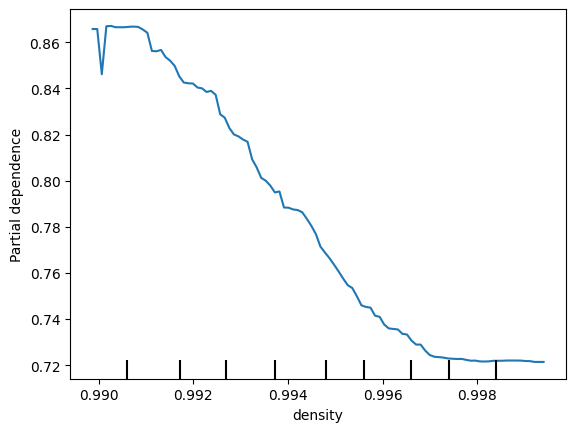

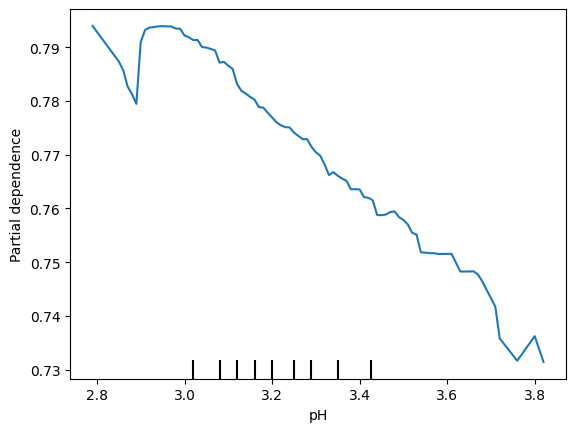

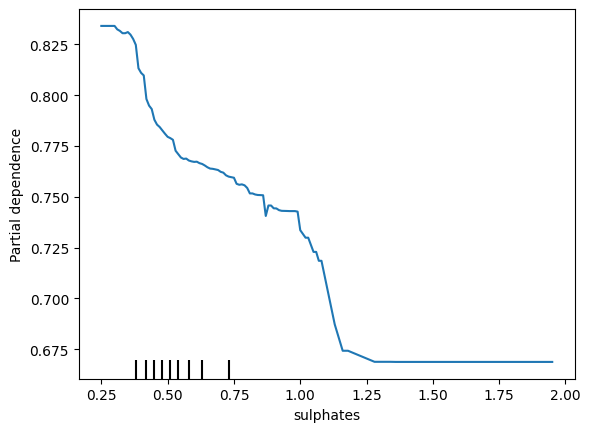

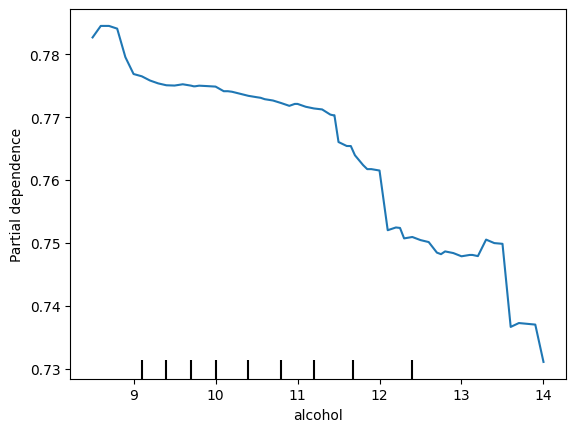

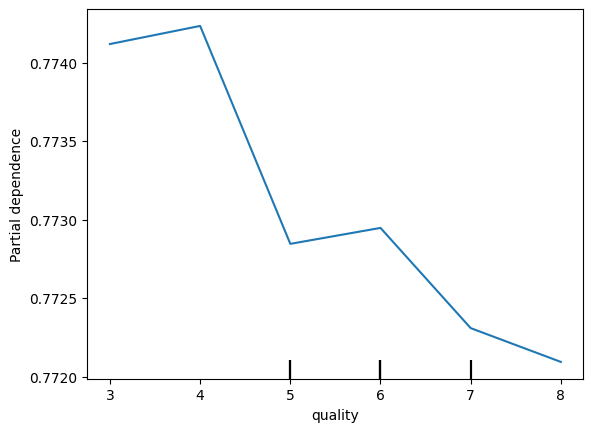

In [35]:
# code from Dr. Bent's global_explanations.ipynb
# adapting it slightly to loop and show plots for all of my features

# Use PartialDependenceDisplay to plot PDP
for f in features:
    PartialDependenceDisplay.from_estimator(
        rf_model, X_test, [f], kind="average"
    )  # kind='both'

# Chat GPT-5 wwas used 2:37pm on 9/25 because after I adapted the code from Dr.Bent's notebook to loop across features
# I was getting an error just referencing f in my PartialDependenceDisplay call,
# so I fed the error to GPT5 and it pointed out that i need to add brackets around f since the function was interpreting it as me passing it the string 'f'

#### Interpretations of the PDP plots  
(Important to consider changes in yaxis, as plots use differing yaxis scales!)
* Fixed Acidity: The probability of white is fairly stable at lower values, but then drops steadily after around 8 and flattens around 11-12. 
* Volatile Acidity: Consistent decrease as volatile acidity goes up
* Citric Acid: Rises up sharply between 0.25 and 0.35, and then plateaus
* Residual Sugar: little U-shape at the start then steady increase til a plateau at 12 
* Chlorides: steady decline overall, with a sharp dip around 0.06–0.07, then pretty flat above 0.08.
* Free Sulfur: quick lift up to 15–25, a small bump near ~50–60, then it levels off.
* Total Sulfur: strong, almost linear increase, with small kinks, but does not have the same strong plateau as free sulfur.
* Density: clean downward slope, then it flattens
* pH: blip near 2.9, then gradual slide down.
* Sulphates: downward trend with a notable drop around ~1.1, then flattens.
* Alcohol: Somewhatgentle and flat decline, with drops around 12 and 13.5
* Quality: Change in prediction is small, telling us that wine quality does not strongly influence type prediction, which makes sense since quality is a rating and not tied to a wine type.

Key takeaways from the PDP plots are white predictions appear more when sulfur dioxide (both kinds) and residual sugars are high and when pH is lower. There were some clear plateaus, specifically in fixed acidity, sulfurs, chlorides and sulfates, meaning that once you're past a moderate level the prediction doesnt change much.

## ICE Plots

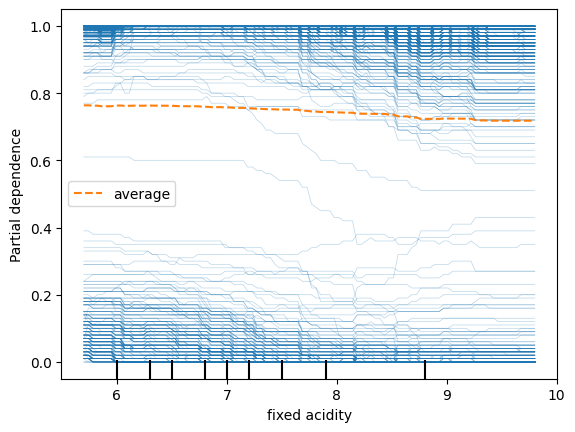

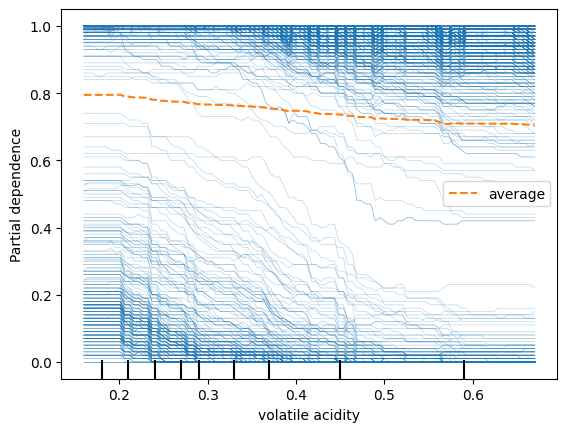

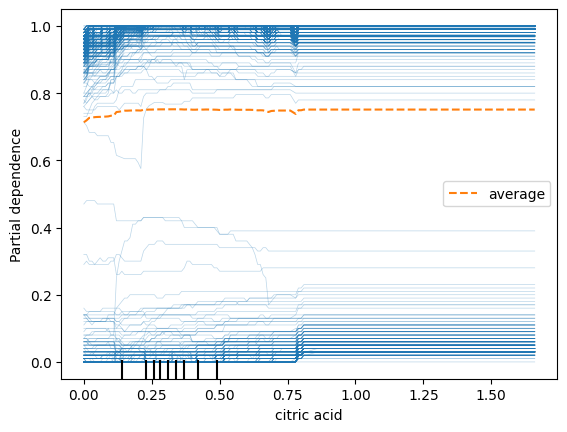

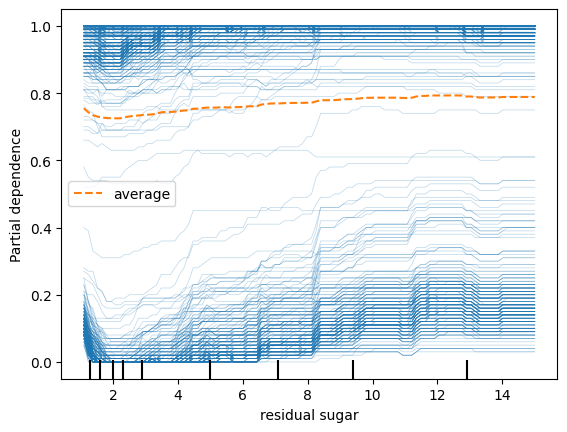

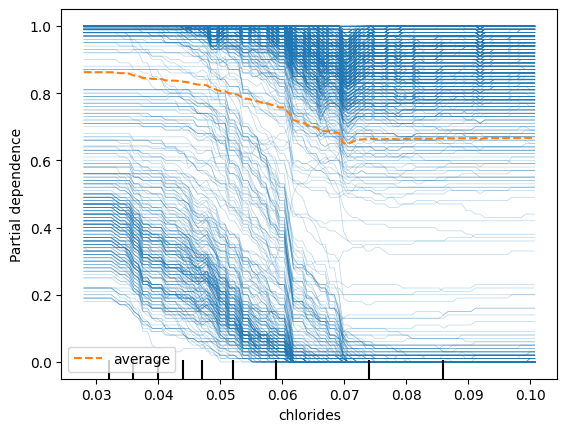

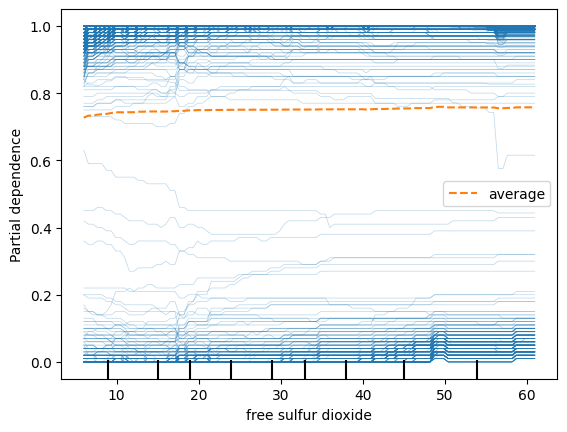

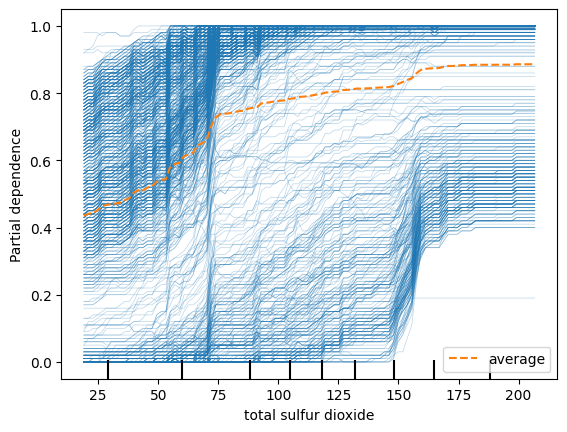

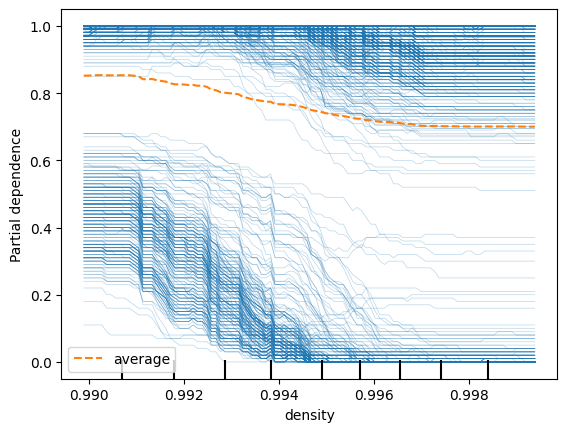

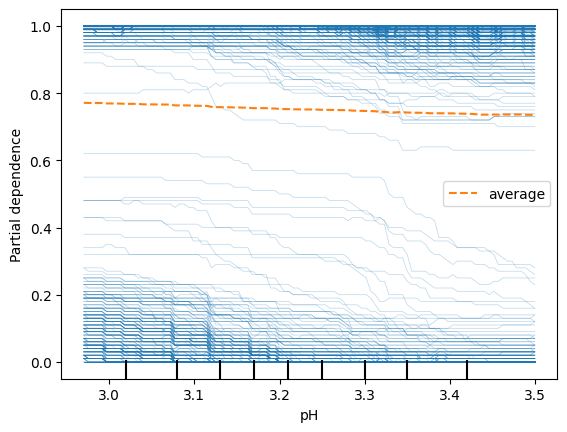

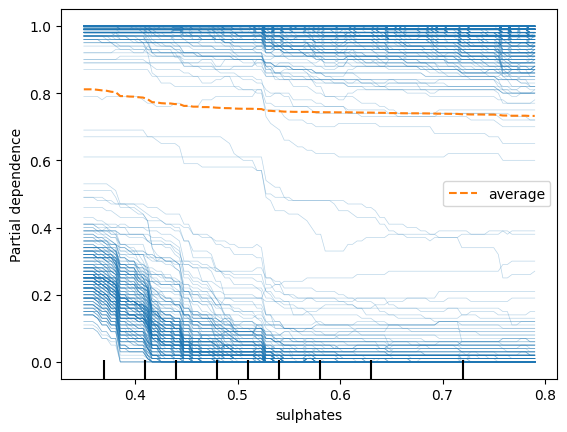

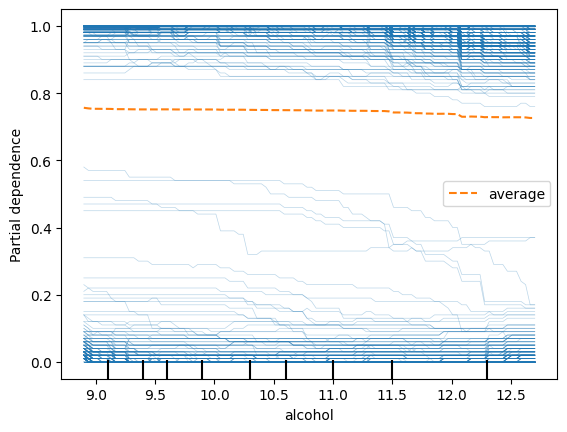

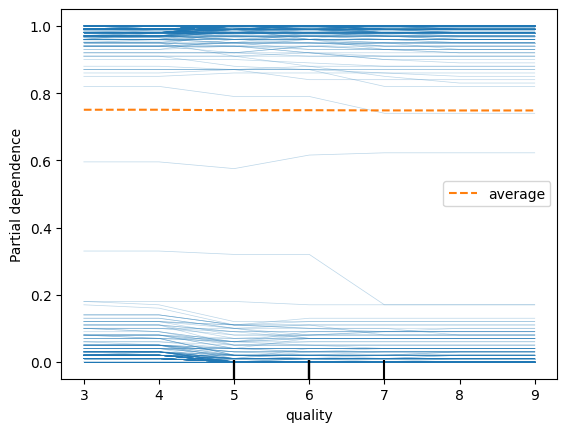

In [66]:
# code from Dr. Bent's global_explanations.ipynb
# adapting it slightly to loop and show plots for all of my features
for f in features:
    PartialDependenceDisplay.from_estimator(
        rf_model, X_train, [f], kind="both"
    )  # including the PDP overlay

#### Interpretations of the ICE plots
The PDP plots are the averages of the ICE plots (shown in the dashed orange line on the plots). Will focus on key takeways here.  
Many of the plots have lines moving together, like volatile acidity, residual sugar, chlorides, free sulfur and sulphates, meaning that there are consistent effects.  There are a couple of plots where the lines are not moving parallel, specfically fixed acidity, density, pH, (and possibly total sulfur dioxide), meaning the impact of the feature varies by the wine. This is insight we are able to see in ICE plots, but whose nuance is lost in the averaged PDP plot
Quality looks flat, reiteterating the earlier takeaway of quality not strongly effecting the model's decisions

## ALE Plots

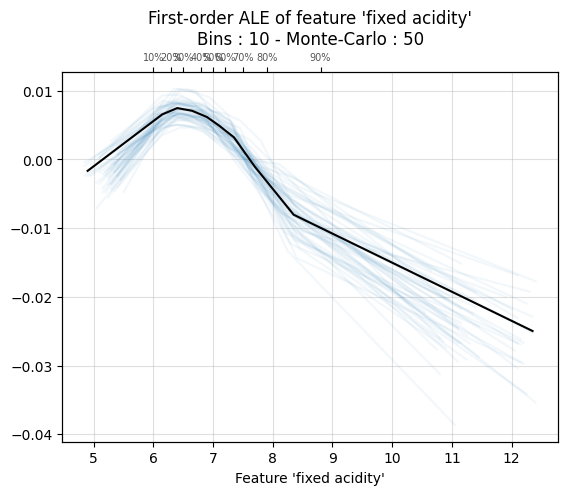

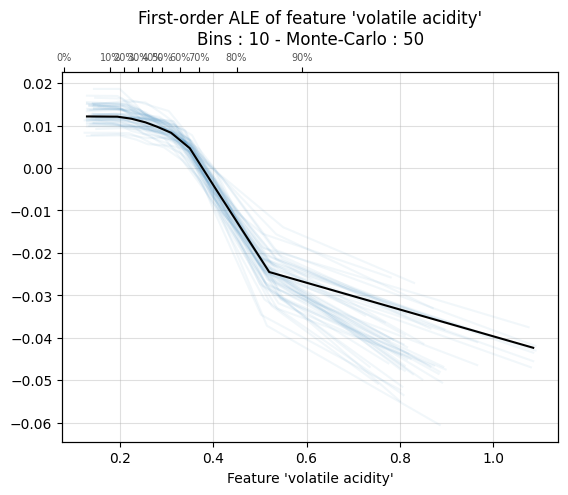

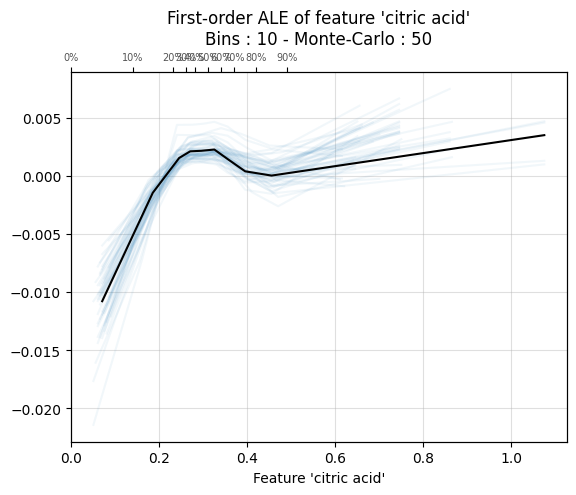

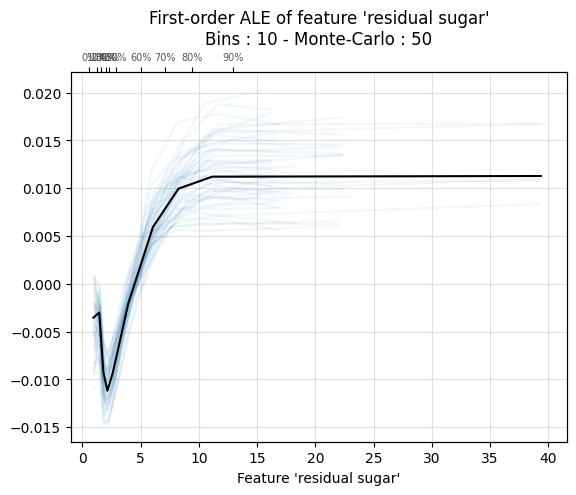

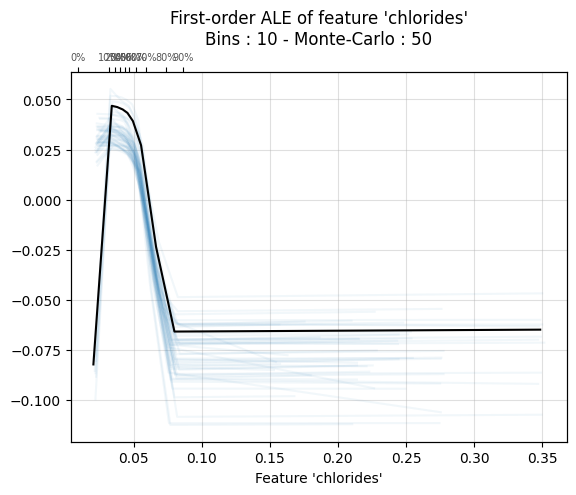

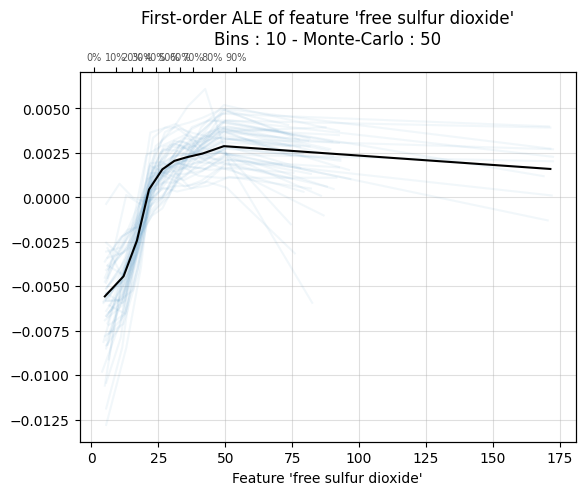

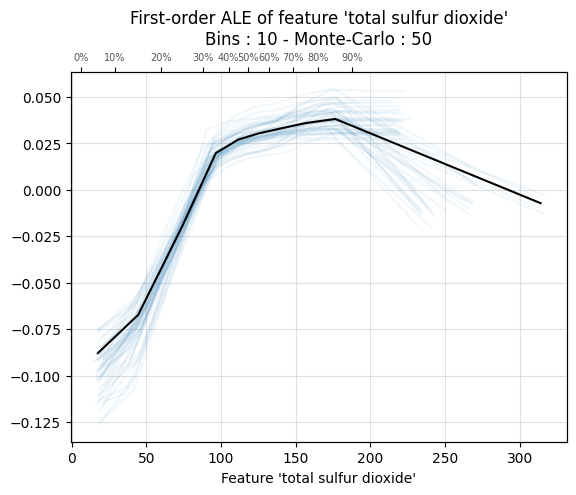

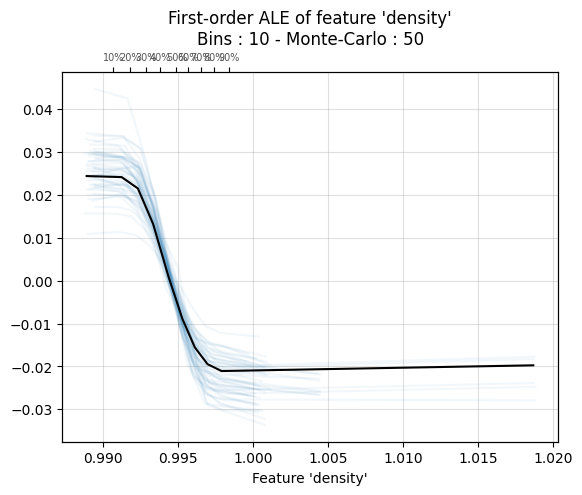

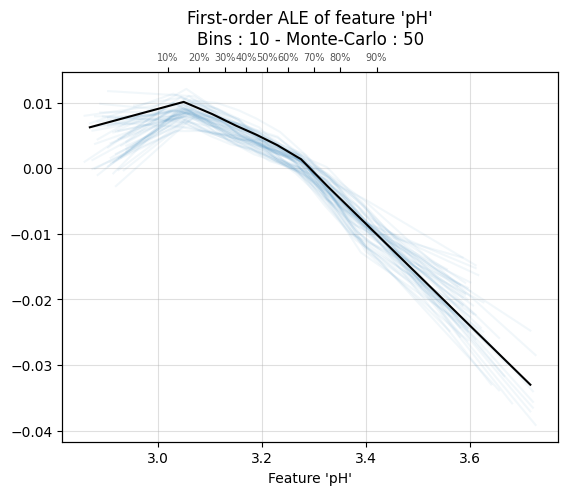

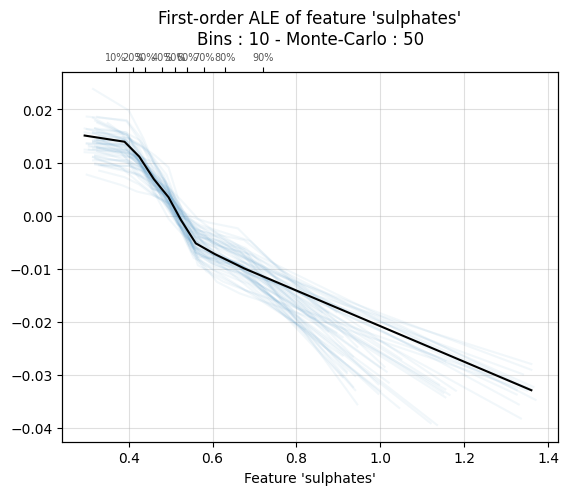

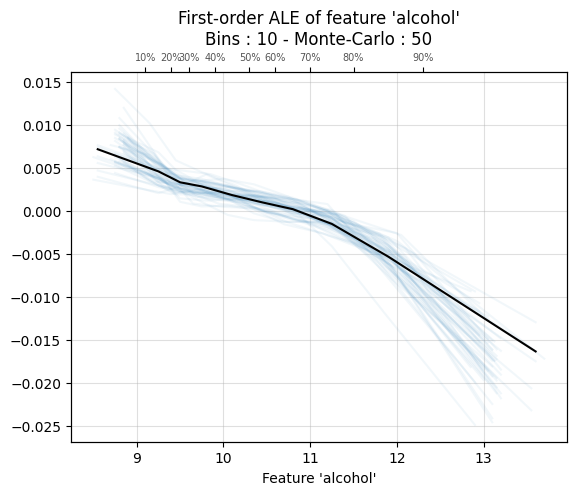

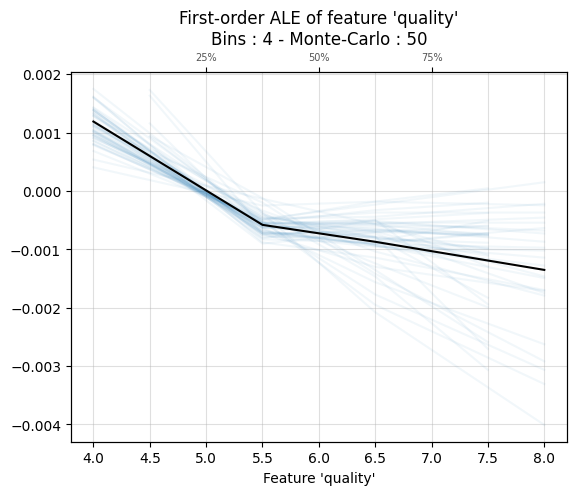

In [69]:
# I was using Dr. Bent's ALE code in global_explanations.ipynb as a reference here
# But, because my RF model outputs a string label instead of a binary 0/1, I was getting an error
# I used ChatGPT-5 on 9/28/25 at 10:31pm, feeding it my error to understand the cause
# it then pointed out for ALE plots to work in my case I need to pick a target
# ChatGPT-5 generated the following code which adapts Dr.Bent's code to work in my situation

# pick the class you want to explain
TARGET = "white"  # change to "red" if needed

# Kayla: Though I selected white as the target here,
# I reran the code and switched to a target of red and it was a flipped on
# xaxis version of the same plots, which makes sense

class_idx = list(rf_model.classes_).index(TARGET)


def proba_target(X):
    return rf_model.predict_proba(X)[:, class_idx]  # numeric 0..1


for f in features:
    ale_plot(
        rf_model,
        X_train,
        [f],
        predictor=proba_target,  # <-- key change
        monte_carlo=True,
    )

#### Interpretations of ALE plots

ALE plots are centered around 0, with values above 0 in this case showing increase in prediction for white wine, as this was selected as our target class in our code. From the plots we can see that white wines are more prominent when sulfur dioxide, both free and total, are higher, and when residual sugars are higher (plateaus). Lower pH also pushes towards white. Higher volattile acidity, sulphates, alcohol and density push toward red. Chloride has a strong drop towards red around 0.05. Residual sugars has a strong jump toward white starting around 2. 

## Final Thoughts